<a href="https://colab.research.google.com/github/pachterlab/gget_examples/blob/main/scRNAseq_workflow/2_downstream_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will demonstrate how `gget` can assist downstream analysis of single-cell RNA sequencing data. We will use the single-cell transcriptome of the retinal fovea of a 2-year old macaque published in [Yi, et al. 2021](https://academic.oup.com/nsr/article/8/4/nwaa179/5896967) as an example dataset.  

[Link to data preprocessing notebook](https://github.com/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/1_align_quality-control_cluster.ipynb)  
[Raw data link](https://ngdc.cncb.ac.cn/gsa/browse/CRA002680/CRR138429)

This notebook was written by Laura Luebbert and inspired by the [kallisto bustools tutorials](https://www.kallistobus.tools/tutorials/kb_building_atlas/python/kb_analysis_0_python/) for single-cell RNA-seq written by A. Sina Booeshaghi and Lior Pachter.

___

Install `gget` and clone the [gget_examples](https://github.com/pachterlab/gget_examples) repository:

In [1]:
!git clone https://github.com/pachterlab/gget_examples.git -q
!pip install gget -q

     |████████████████████████████████| 1.2 MB 9.3 MB/s 
     |████████████████████████████████| 25.2 MB 1.4 MB/s 
     |████████████████████████████████| 128 kB 56.6 MB/s 


Import gget:

In [2]:
import gget

Thu May 26 23:23:38 2022 INFO NumExpr defaulting to 2 threads.


In [ ]:
# # Show the manual of any gget submodule, e.g. gget.seq:
# help(gget.seq)

Import other packages for scRNA-seq analysis:

In [ ]:
!pip install anndata scanpy==1.7.2 matplotlib==3.1.3 leidenalg -q
%config InlineBackend.figure_format = 'retina'

import anndata
import numpy as np
import pandas as pd

# Change the directory to the scRNAseq_workflow folder for ease
import os
os.chdir("/content/gget_examples/scRNAseq_workflow")

# Import custom plotting functions
import funcs

___

Load the [pre-processed data](https://github.com/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/1_align_quality-control_cluster.ipynb):

In [ ]:
# Concatenate the split files in the data folder into a single h5ad file
!cd data/ && cat xaa xab xac > macaque_preprocessed.h5ad

In [ ]:
adata = anndata.read_h5ad("data/macaque_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 9991 × 35432
    obs: 'n_counts_processed', 'leiden'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

___

# Celltype assignment based on known marker genes

We will define a dictionary containing the expected celltypes and their respective marker genes (reference: [Supplementary Table 2](https://academic.oup.com/nsr/article/8/4/nwaa179/5896967?login=true#supplementary-data)). For ease and speed, we are only defining one marker per celltye.

In [ ]:
marker_gene_dict = {
    "amacrine cells": "ATP1B1",
    "astrocytes": "GFAP",
    "bipolar cells": "PCP2",
    "cones": "ARR3",
    "ganglion cells": "SNCG",
    "horizontal cells": "PVALB",
    "Müller glia": "FRZB",
    "microglia": "CD74",
    "endothelial cells/ pericytes": "IGFBP7",
    "rods": "rhodopsin",
}

# `gget.search` to find the Ensembl IDs of the known marker genes:

In [ ]:
# wrap_text=True displays the data frame with wrapped text
ens_marker_genes = gget.search(list(marker_gene_dict.values()), "macaca_m", wrap_text=True)

Wed May 25 03:52:46 2022 INFO Fetching results from database: macaca_mulatta_core_106_10
Wed May 25 03:52:53 2022 INFO Total matches found: 11.
Wed May 25 03:52:53 2022 INFO Query time: 8.66 seconds.


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url
0,ENSMMUG00000021078,ATP1B1,ATPase Na+/K+ transportingsubunit beta 1 [Source:VGNCSymbol;Acc:VGNC:70176],ATPase Na+/K+ transportingsubunit beta 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000021078
1,ENSMMUG00000013115,GFAP,glial fibrillary acidicprotein [Source:VGNCSymbol;Acc:VGNC:72913],glial fibrillary acidicprotein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000013115
2,ENSMMUG00000060224,PCP2,Purkinje cell protein 2[Source:VGNCSymbol;Acc:VGNC:75706],Purkinje cell protein 2,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000060224
3,ENSMMUG00000013935,ARR3,arrestin 3 [Source:VGNCSymbol;Acc:VGNC:70020],arrestin 3,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000013935
4,ENSMMUG00000011849,SNCG,synuclein gamma [Source:VGNCSymbol;Acc:VGNC:77671],synuclein gamma,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000011849
5,ENSMMUG00000008778,PVALB,parvalbumin [Source:VGNCSymbol;Acc:VGNC:76627],parvalbumin,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000008778
6,ENSMMUG00000014396,FRZB,frizzled related protein[Source:VGNCSymbol;Acc:VGNC:72819],frizzled related protein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000014396
7,ENSMMUG00000009113,CD74,CD74 molecule [Source:VGNCSymbol;Acc:VGNC:70779],CD74 molecule,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000009113
8,ENSMMUG00000014011,IGFBP7,insulin like growth factorbinding protein 7 [Source:VGNCSymbol;Acc:VGNC:73578],insulin like growth factorbinding protein 7,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000014011
9,ENSMMUG00000021223,RRH,retinal pigment epithelium-derived rhodopsin homolog[Source:VGNCSymbol;Acc:VGNC:76940],retinal pigment epithelium-derived rhodopsin homolog,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000021223


Let's find these Ensembl IDs in our dataset index. **This approach has the advantage that even genes not annotated with their gene name in the reference genome can be found.**

In [ ]:
marker_genes = funcs.find_ids(adata, ens_marker_genes["ensembl_id"].values)
marker_genes

['ATP1B1_ENSMMUG00000021078.4',
 'GFAP_ENSMMUG00000013115.4',
 'PCP2_ENSMMUG00000060224.1',
 'ARR3_ENSMMUG00000013935.4',
 'SNCG_ENSMMUG00000011849.4',
 'PVALB_ENSMMUG00000008778.4',
 'FRZB_ENSMMUG00000014396.4',
 'CD74_ENSMMUG00000009113.4',
 'IGFBP7_ENSMMUG00000014011.4',
 'RRH_ENSMMUG00000021223.4',
 'RHO_ENSMMUG00000055315.1']

Let's rank the marker genes per cluster for the celltype assignment:

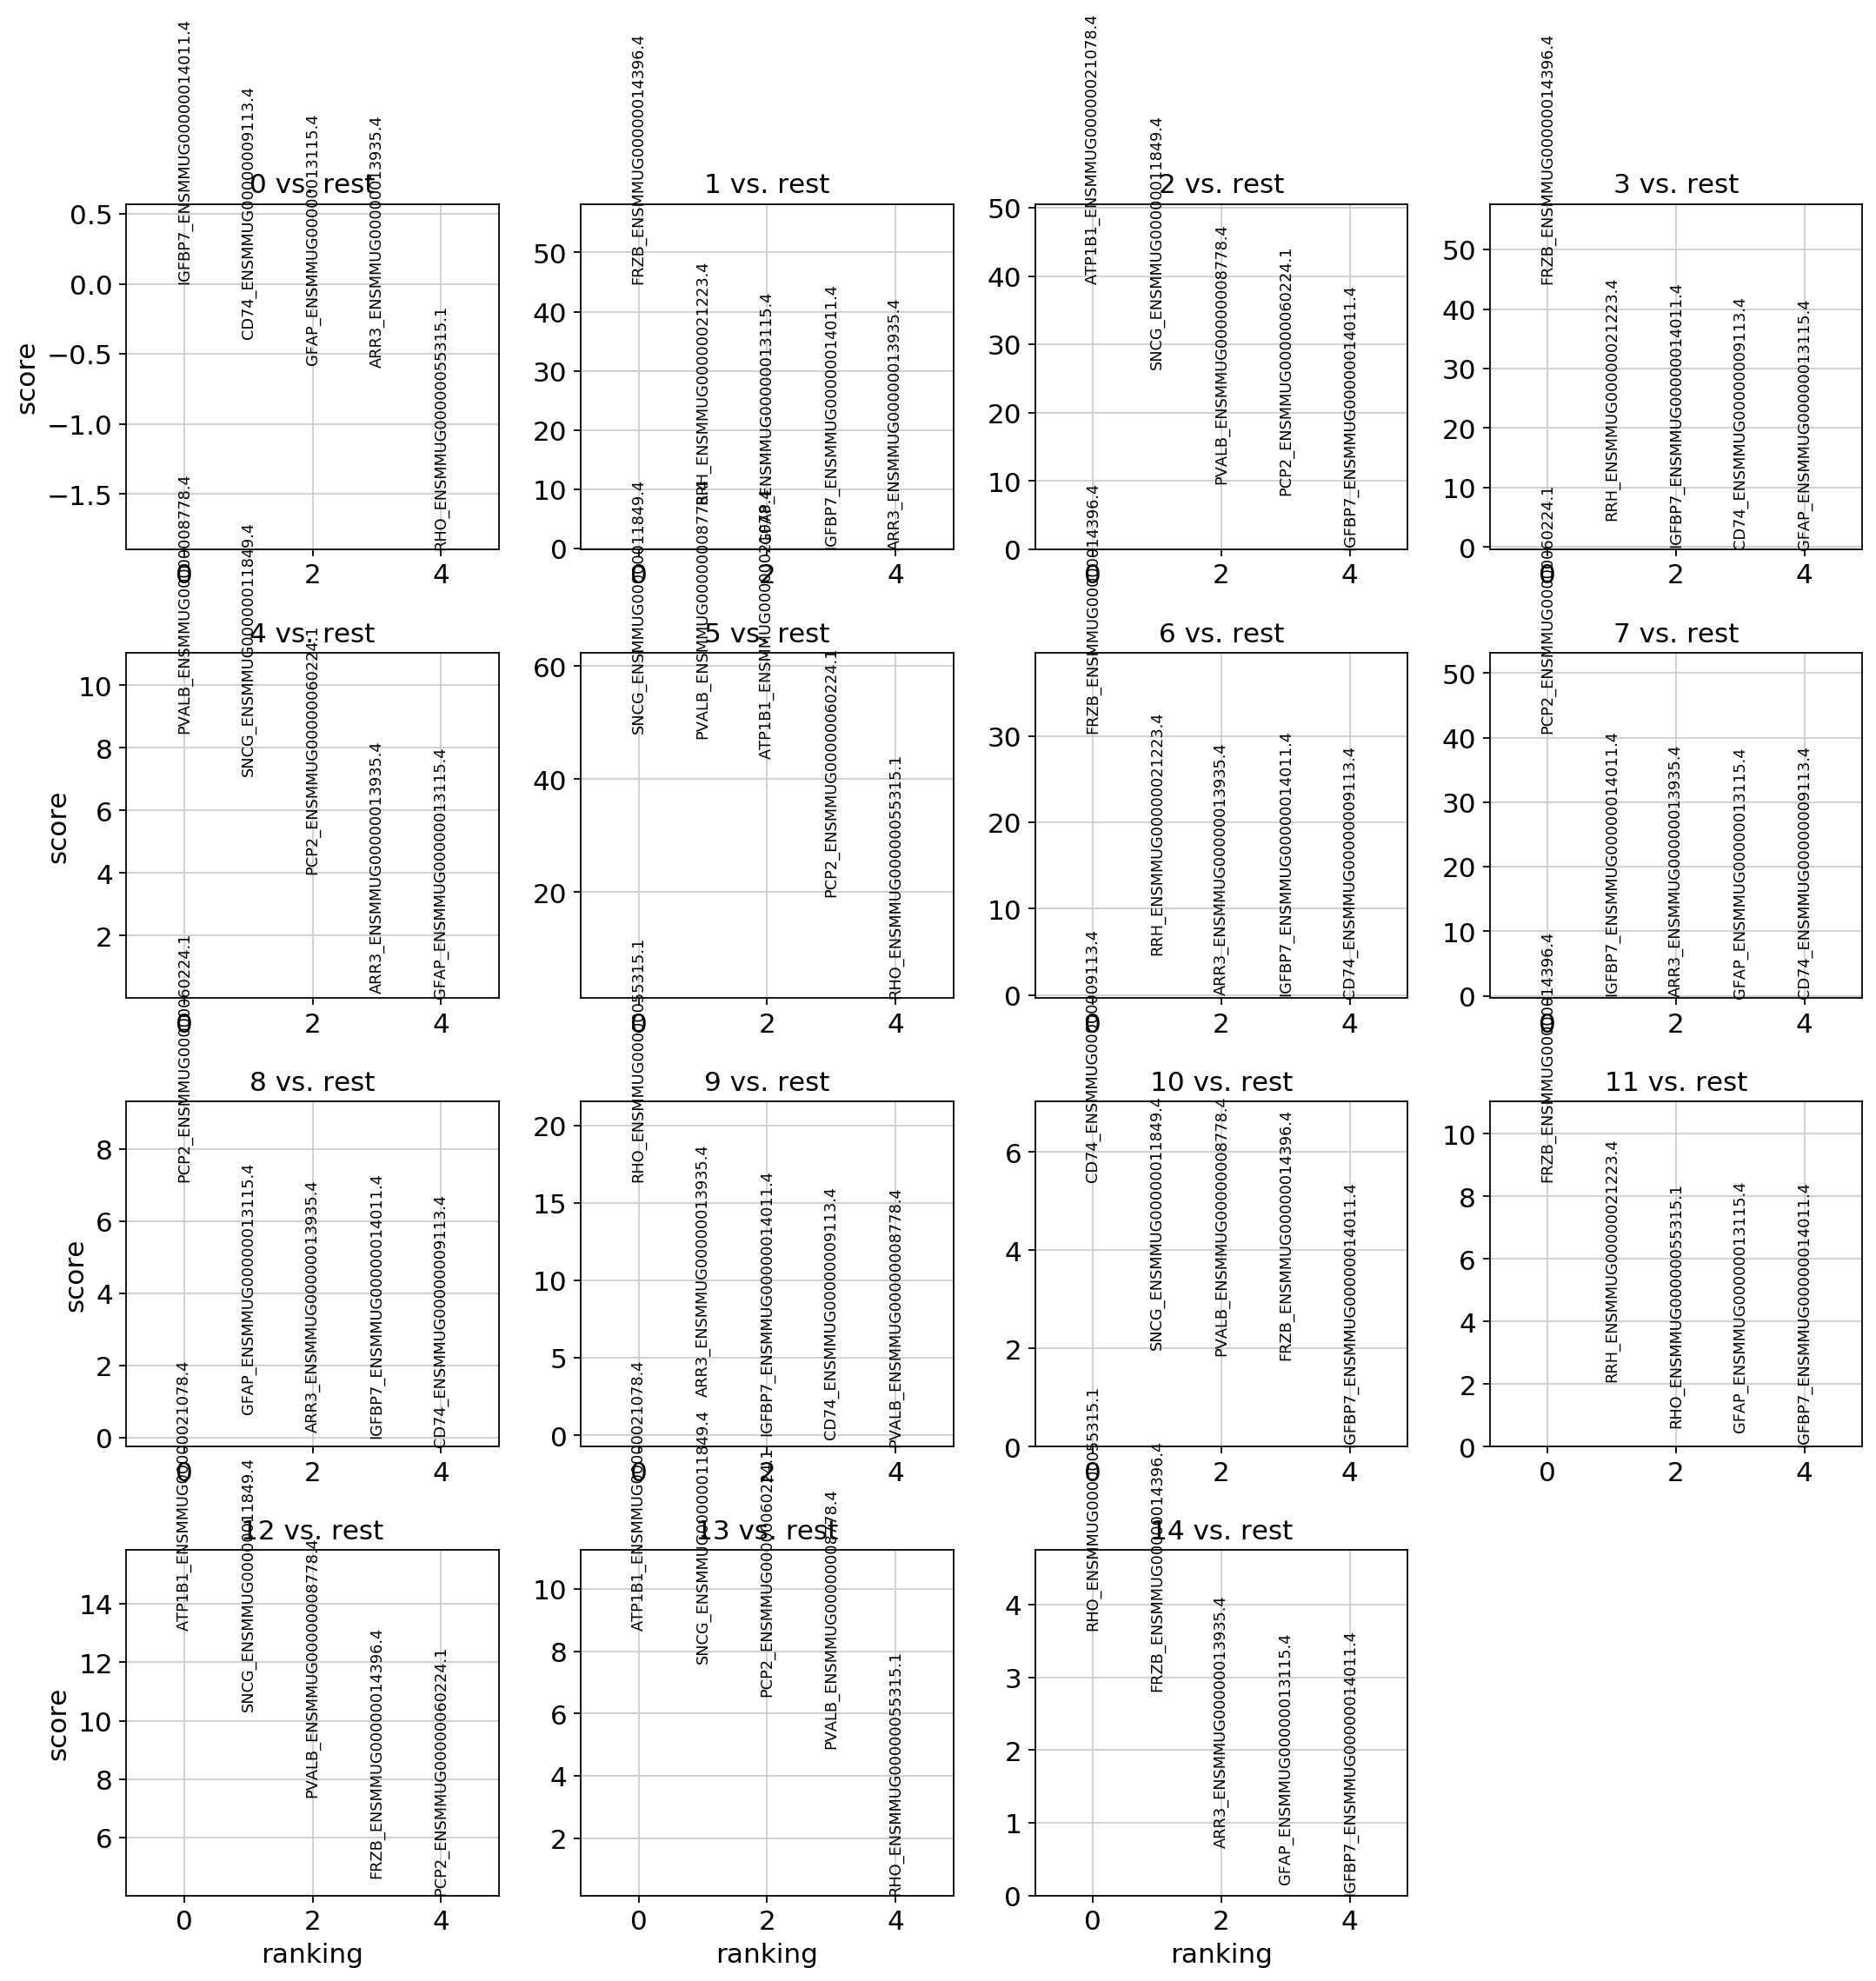

In [ ]:
funcs.rank_marker_genes(adata, marker_genes, marker_gene_dict)

Next, we will use the ranked marker genes to manually define the celltype for each cluster:

In [ ]:
df_leiden = pd.DataFrame()
df_leiden["leiden_cluster"] = np.arange(15)

# Define cluster celltype
df_leiden["celltype"] = [
    "Endothelial cells/\npericytes 1",
    "Müller glia 3",
    "Amacrine cells 2",
    "Müller glia 2",
    "Horizontal cells",
    "Ganglion cells 1",
    "Müller glia 4",
    "Bipolar cells 1",
    "Bipolar cells 2",
    "Rods 1",
    "Microglia",
    "Müller glia 1",
    "Amacrine cells 1",
    "Ganglion cells 2",
    "Rods 2",
]

# Assign a color to each celltype
df_leiden["celltype_colors"] = [
    "cornflowerblue",
    "coral",
    "orchid",
    "orangered",
    "darkblue",
    "darkgreen",
    "moccasin",
    "royalblue",
    "lightskyblue",
    "mediumvioletred",
    "darkorange",
    "crimson",
    "indigo",
    "mediumseagreen",
    "orchid",
]

df_leiden.head()

,leiden_cluster,celltype,celltype_colors
0,0,Endothelial cells/\npericytes 1,cornflowerblue
1,1,Müller glia 3,coral
2,2,Amacrine cells 2,orchid
3,3,Müller glia 2,orangered
4,4,Horizontal cells,darkblue


Create a column in adata.obs to store the celltype for each cell:

In [ ]:
adata.obs["celltype"] = adata.obs.leiden.copy()
adata.rename_categories("celltype", df_leiden["celltype"].values)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Let's check how we did with the celltype assignment by plotting all differentially expressed genes (not just the marker genes):

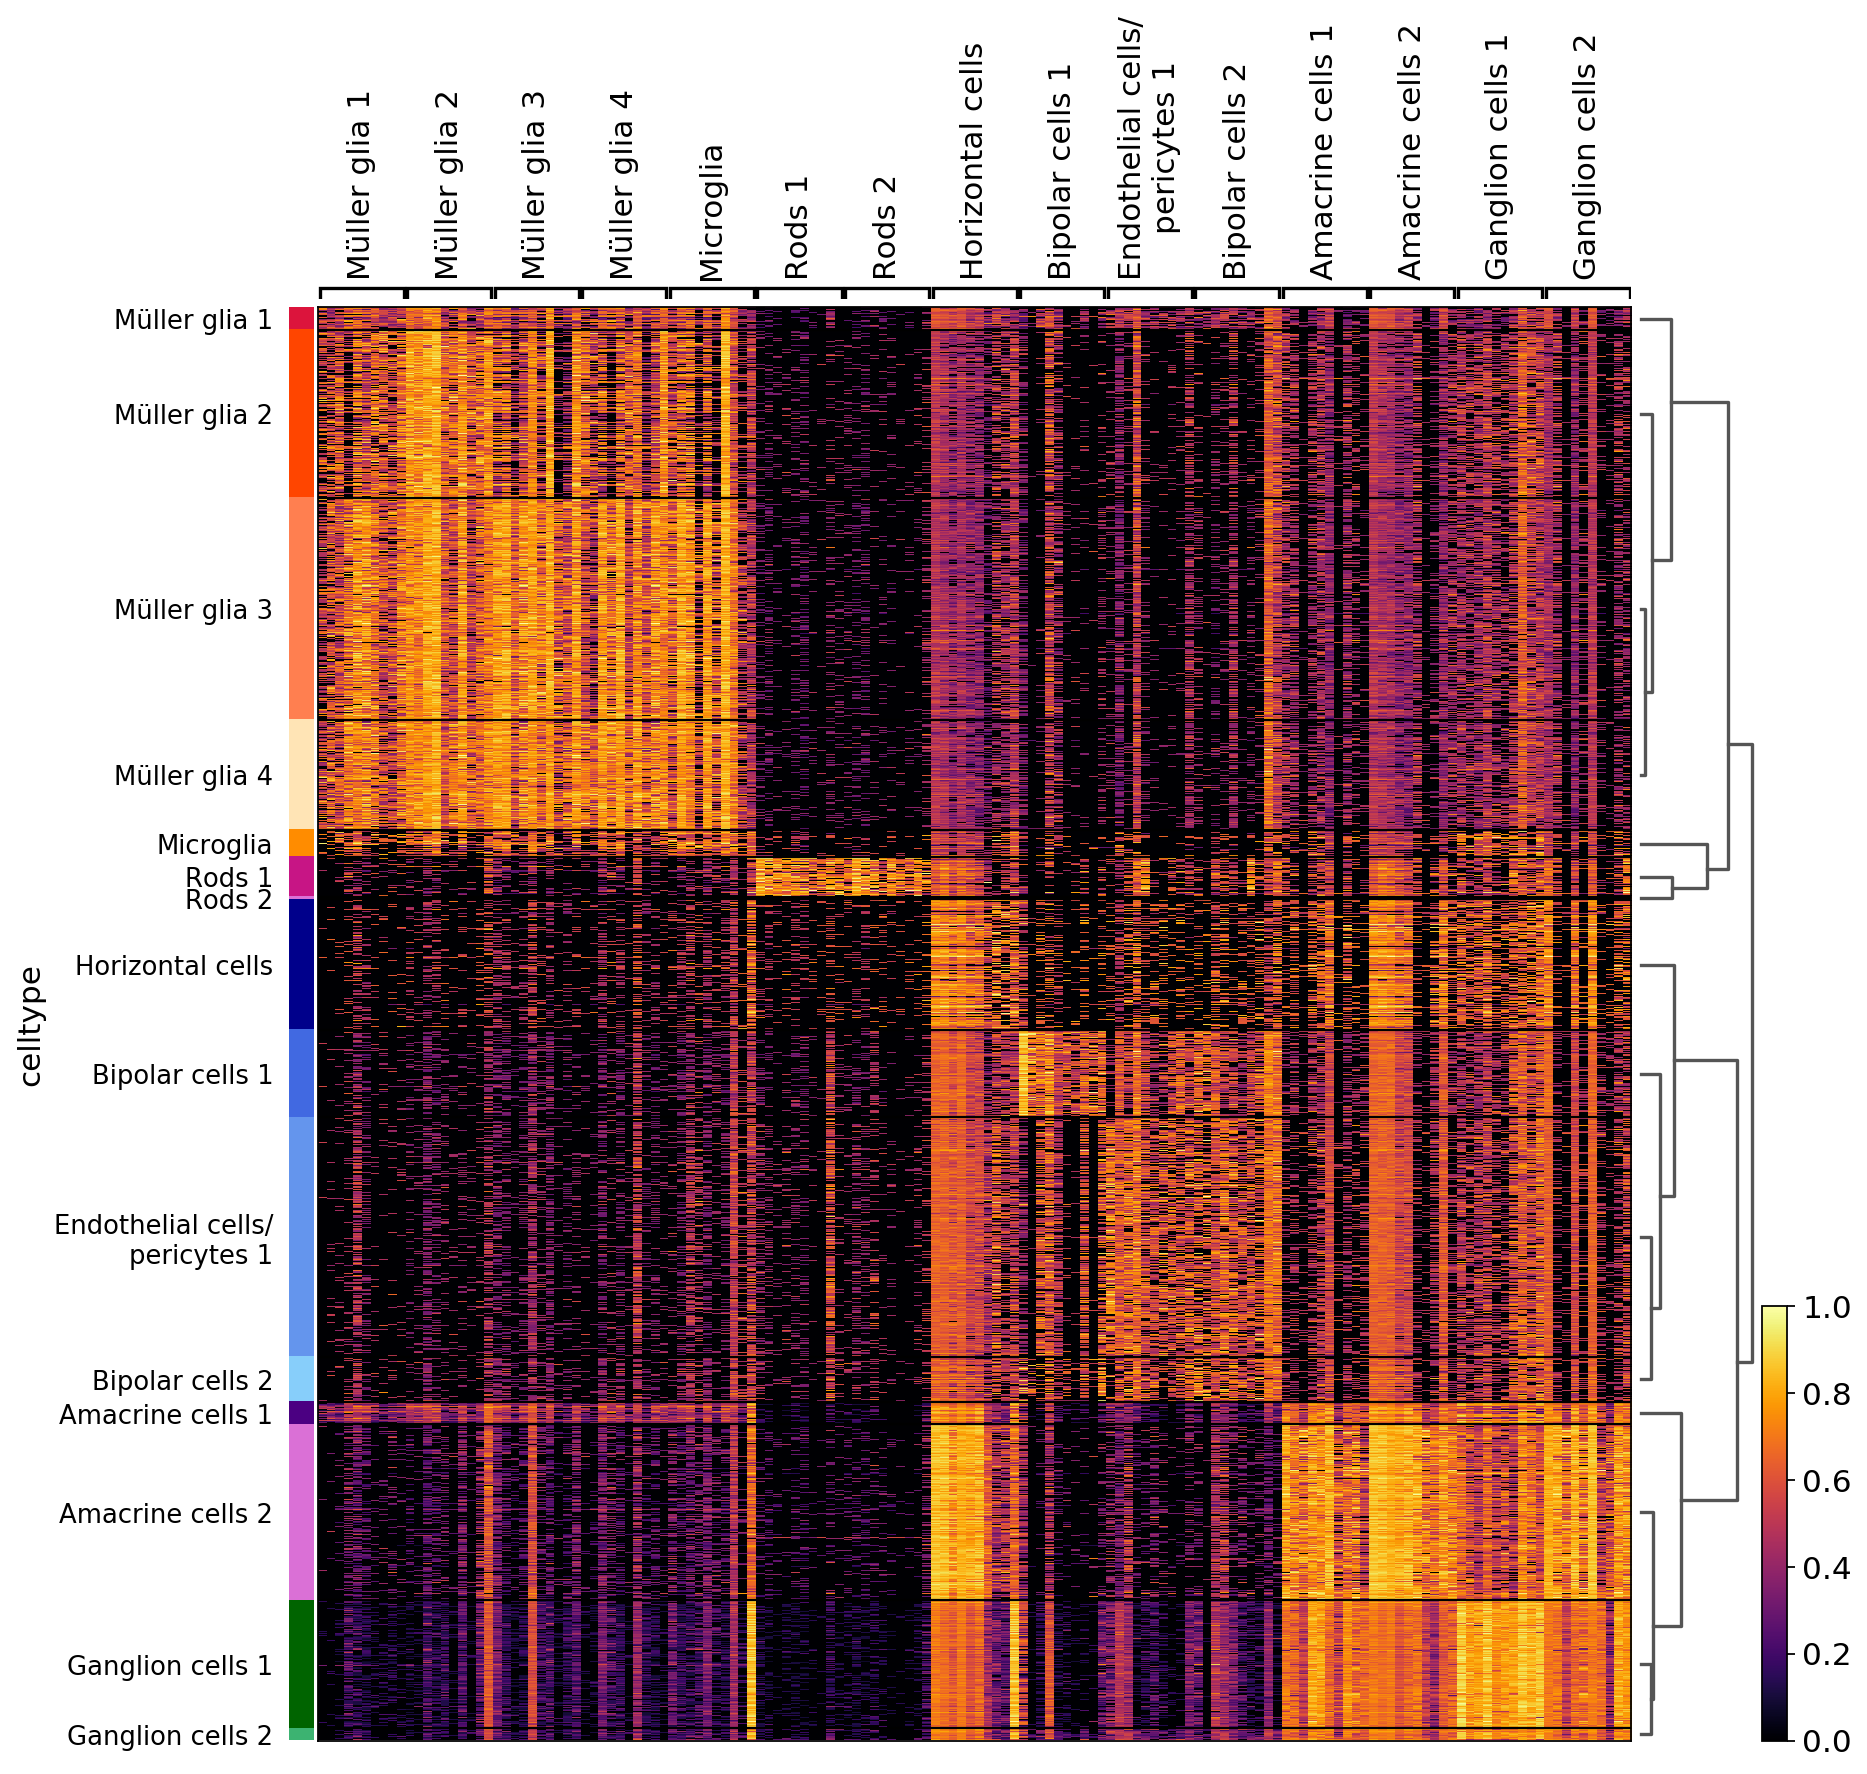

In [ ]:
funcs.celltype_heatmap(adata, df_leiden["celltype_colors"], figsize=(12, 12))

We can see that clusters assigned the same celltype show similar overall expression patterns, as expected.

___

# Differentially expressed genes analysis
Below, we will show how `gget` can assist the analysis of differentially expressed (DE) genes as an example downstream analysis. In the celltype assignment above, we found two population of bipolar cells. We will use DE gene analysis to visualize the difference between these clusers.

First, let's find DE genes between the two cell populations. We will compute the fold change and p-value difference for all genes between the defined conditions:

In [ ]:
# Define masks of conditions to compare
control_mask = np.where(adata.obs["celltype"]=="Bipolar cells 1")
experiment_mask = np.where(adata.obs["celltype"]=="Bipolar cells 2")

df_volcano = funcs.volcano_df(adata, control_mask, experiment_mask)
df_volcano.head()

,GeneNames,control,experiment,logFC,p-value
0,_ENSMMUG00000023296.4,0.000000,0.000000,0.000000,NaN
1,U6_ENSMMUG00000036181.3,0.000000,0.000000,0.000000,NaN
2,ZNF692_ENSMMUG00000000634.4,0.058549,0.031487,0.027063,0.172397
3,ZNF672_ENSMMUG00000037875.2,0.003024,0.013586,-0.010562,0.294305
4,SH3BP5L_ENSMMUG00000000632.4,0.096787,0.066643,0.030144,0.253028


Plot volcano plot to visualize the DE genes (significantly DE genes are marked in red):

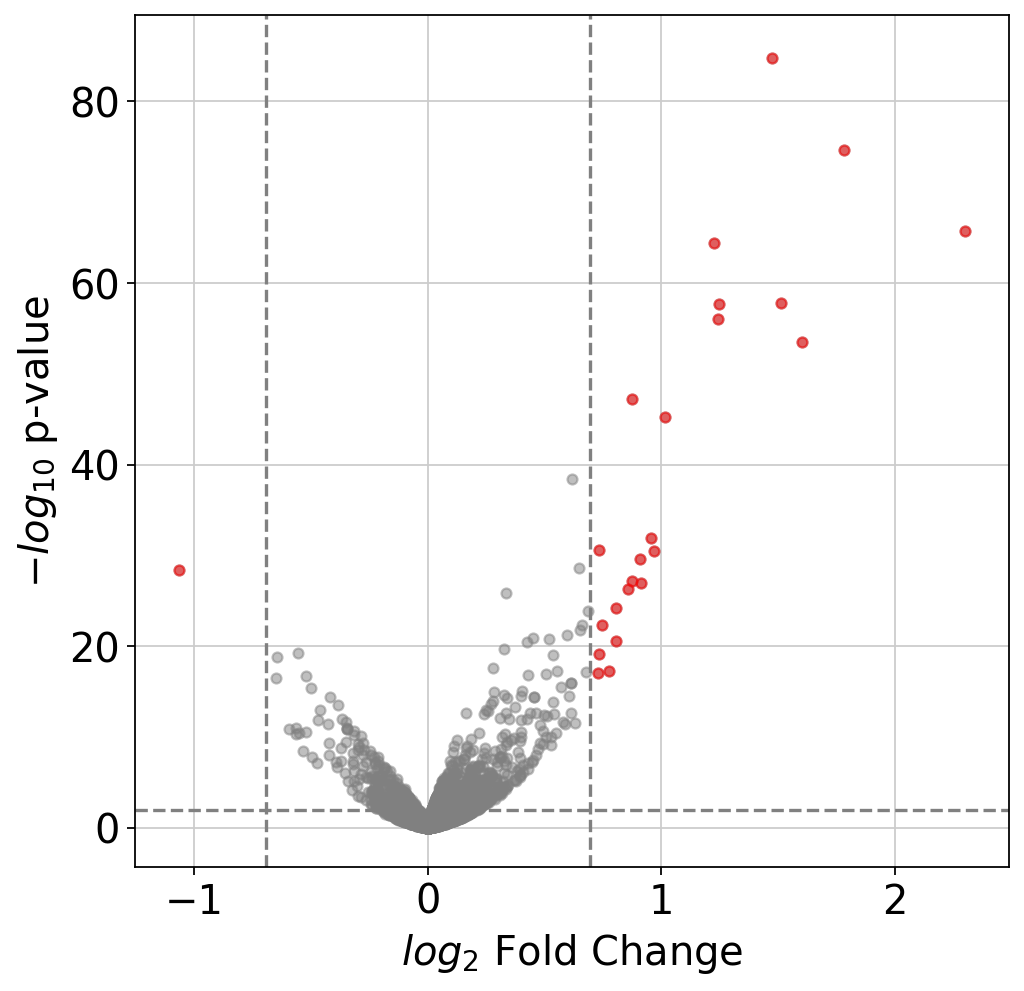

In [ ]:
# Define minimum fold change and p-value alpha for volcano plot thresholds
min_fold_change = 2
alpha = 0.01

funcs.volcano_plot(df_volcano, min_fold_change=min_fold_change, alpha=alpha)

Get a list of genes that were significantly higher expressed in the second population of bipolar cells (these are the genes marked by a red dot to the right on the plot above):

In [ ]:
mask = np.logical_and(df_volcano["logFC"] > np.log(min_fold_change), df_volcano["p-value"] < alpha)
# Sort by fold change
df_de_genes = df_volcano[mask].sort_values("logFC")

# Get the Ensembl ID of all the DE genes
ens_ids = []
for gene in df_de_genes["GeneNames"].values:
    ens_ids.append(gene.split("_")[1])
df_de_genes["EnsemblID"] = ens_ids

# Reset index
df_de_genes = df_de_genes.reset_index(drop=True)

# Show first 5 DE genes
df_de_genes.head()

,GeneNames,control,experiment,logFC,p-value,EnsemblID
0,PCP2_ENSMMUG00000060224.1,4.646170,2.347392,2.298778,1.748505e-66,ENSMMUG00000060224.1
1,CCDC136_ENSMMUG00000009625.4,2.646356,0.865758,1.780599,2.061198e-75,ENSMMUG00000009625.4
2,TSHB_ENSMMUG00000058261.1,2.746544,1.143520,1.603024,3.209607e-54,ENSMMUG00000058261.1
3,RGS16_ENSMMUG00000055481.1,2.822387,1.309187,1.513199,1.436695e-58,ENSMMUG00000055481.1
4,ATP6V1H_ENSMMUG00000004064.4,1.896165,0.424468,1.471697,1.912654e-85,ENSMMUG00000004064.4


# `gget.info` to fetch information about genes
We can see that some of the DE genes are not annotated with a gene name. Let's use gget.info to get the names, description and biotype (if available on the Ensembl, NCBI, or UniProt database) for all DE genes:

In [ ]:
info_df = gget.info(df_de_genes["EnsemblID"], wrap_text=True)

Wed May 25 04:02:25 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000015972. Returning all unreviewed results.
Wed May 25 04:02:29 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000051357. Returning all unreviewed results.
Wed May 25 04:02:33 2022 WARNING No UniProt entry was found for Ensembl ID ENSMMUG00000054106.
Wed May 25 04:02:36 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000053116. Returning all unreviewed results.
Wed May 25 04:02:38 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000021246. Returning all unreviewed results.
Wed May 25 04:02:42 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000005190. Returning all unreviewed results.
Wed May 25 04:02:46 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000007661. Returning all unreviewed results.
Wed May 25 04:02:50 2022 WARNING No reviewed UniProt result

,ensembl_id,uniprot_id,ncbi_gene_id,species,assembly_name,primary_gene_name,ensembl_gene_name,synonyms,parent_gene,protein_names,ensembl_description,uniprot_description,ncbi_description,object_type,biotype,canonical_transcript,seq_region_name,strand,start,end
ENSMMUG00000015972,ENSMMUG00000015972,"[A0A5F7ZMI3, F6XVL2]",693631,macaca_mulatta,Mmul_10,CYP2J2,CYP2J2,[CYP2J2],NaN,Uncharacterized protein,cytochrome P450 family 2subfamily J member 2[Source:VGNCSymbol;Acc:VGNC:99873],NaN,NaN,Gene,protein_coding,ENSMMUT00000054939.2,1,1,164506418,164591891
ENSMMUG00000051357,ENSMMUG00000051357,"[A0A5F7ZSF8, A0A5F8AMB9]",696013,macaca_mulatta,Mmul_10,PRDM8,PRDM8,[PRDM8],NaN,Uncharacterized protein,PR/SET domain 8 [Source:VGNCSymbol;Acc:VGNC:76249],NaN,NaN,Gene,protein_coding,ENSMMUT00000095865.1,5,-1,53511112,53534586
ENSMMUG00000054106,ENSMMUG00000054106,NaN,NaN,macaca_mulatta,Mmul_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gene,lncRNA,ENSMMUT00000080640.1,8,1,64990191,65000159
ENSMMUG00000053116,ENSMMUG00000053116,A0A5F8AEA0,NaN,macaca_mulatta,Mmul_10,NaN,NaN,NaN,NaN,Uncharacterized protein,NaN,NaN,NaN,Gene,protein_coding,ENSMMUT00000091015.1,3,-1,111461994,111475279
ENSMMUG00000021246,ENSMMUG00000021246,"[A0A1D5QWP5, A0A5F7ZUG9, A0A5F7ZY65, A0A5F7ZZI0, A0A5F8AMK9, F7D2F4, F7HRJ1, F7HRJ3, G7MIX6]",NaN,macaca_mulatta,Mmul_10,HHATL,NaN,"[EGK_11753, HHATL, HIGD1A]",NaN,"[HIG1 domain family member 1A isoform a, HIG1 domain-containing protein, Uncharacterized protein]",NaN,NaN,NaN,Gene,protein_coding,ENSMMUT00000029894.4,2,-1,98646979,98755023
ENSMMUG00000005190,ENSMMUG00000005190,F7CTP1,713913,macaca_mulatta,Mmul_10,GNB3,GNB3,"[EGK_03291, GNB3, HG2D]",NaN,G protein subunit beta 3 (Guanine nucleotide-binding protein G(I)/G(S)/G(T) subunit beta-3) (Transducin beta chain 3),G protein subunit beta 3[Source:VGNCSymbol;Acc:VGNC:73096],NaN,NaN,Gene,protein_coding,ENSMMUT00000007309.4,11,1,7006688,7013083
ENSMMUG00000007661,ENSMMUG00000007661,"[A0A1D5RFH0, A0A5F7ZKG5, F7DBB2, F7DBW9]",693315,macaca_mulatta,Mmul_10,EDIL3,EDIL3,"[EDIL3, EGK_16658]",NaN,"[Developmentally-regulated endothelial cell locus 1 protein (EGF like repeats and discoidin domains 3), EGF like repeats and discoidin domains 3]",EGF like repeats and discoidindomains 3 [Source:VGNCSymbol;Acc:VGNC:72156],NaN,NaN,Gene,protein_coding,ENSMMUT00000106416.1,6,-1,80673276,81198956
ENSMMUG00000009430,ENSMMUG00000009430,A0A1D5QCY9,720596,macaca_mulatta,Mmul_10,TRPM1,TRPM1,[TRPM1],NaN,Transient receptor potential cation channel subfamily M member 1,transient receptor potentialcation channel subfamily Mmember 1 [Source:VGNCSymbol;Acc:VGNC:79964],NaN,NaN,Gene,protein_coding,ENSMMUT00000066760.2,7,1,7096043,7246917
ENSMMUG00000051202,ENSMMUG00000051202,NaN,NaN,macaca_mulatta,Mmul_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gene,pseudogene,ENSMMUT00000096104.1,14,1,78141344,78145127
ENSMMUG00000054142,ENSMMUG00000054142,"[A0A5F7Z894, A0A5F8AM23, F6PZV7, F6QZN0, F7ECS1, H9FUP3]",NaN,macaca_mulatta,Mmul_10,"[LOC100424768, MT1A, MT1E]",MT1M,"[EGK_02835, LOC100424768, MT1A, MT1E]",NaN,"[Metallothionein, Uncharacterized protein]",metallothionein 1M[Source:NCBI gene (formerlyEntrezgene);Acc:708679],NaN,NaN,Gene,protein_coding,ENSMMUT00000091183.1,20,1,43833186,43849622


# Enrichment analysis of DE genes with `gget.enrichr` 
We found lots of primary gene names (gene symbols) for our DE genes using `gget.info`! We can directly pass these to `gget.enrichr`. 

Thu May 26 23:23:39 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Thu May 26 23:23:39 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


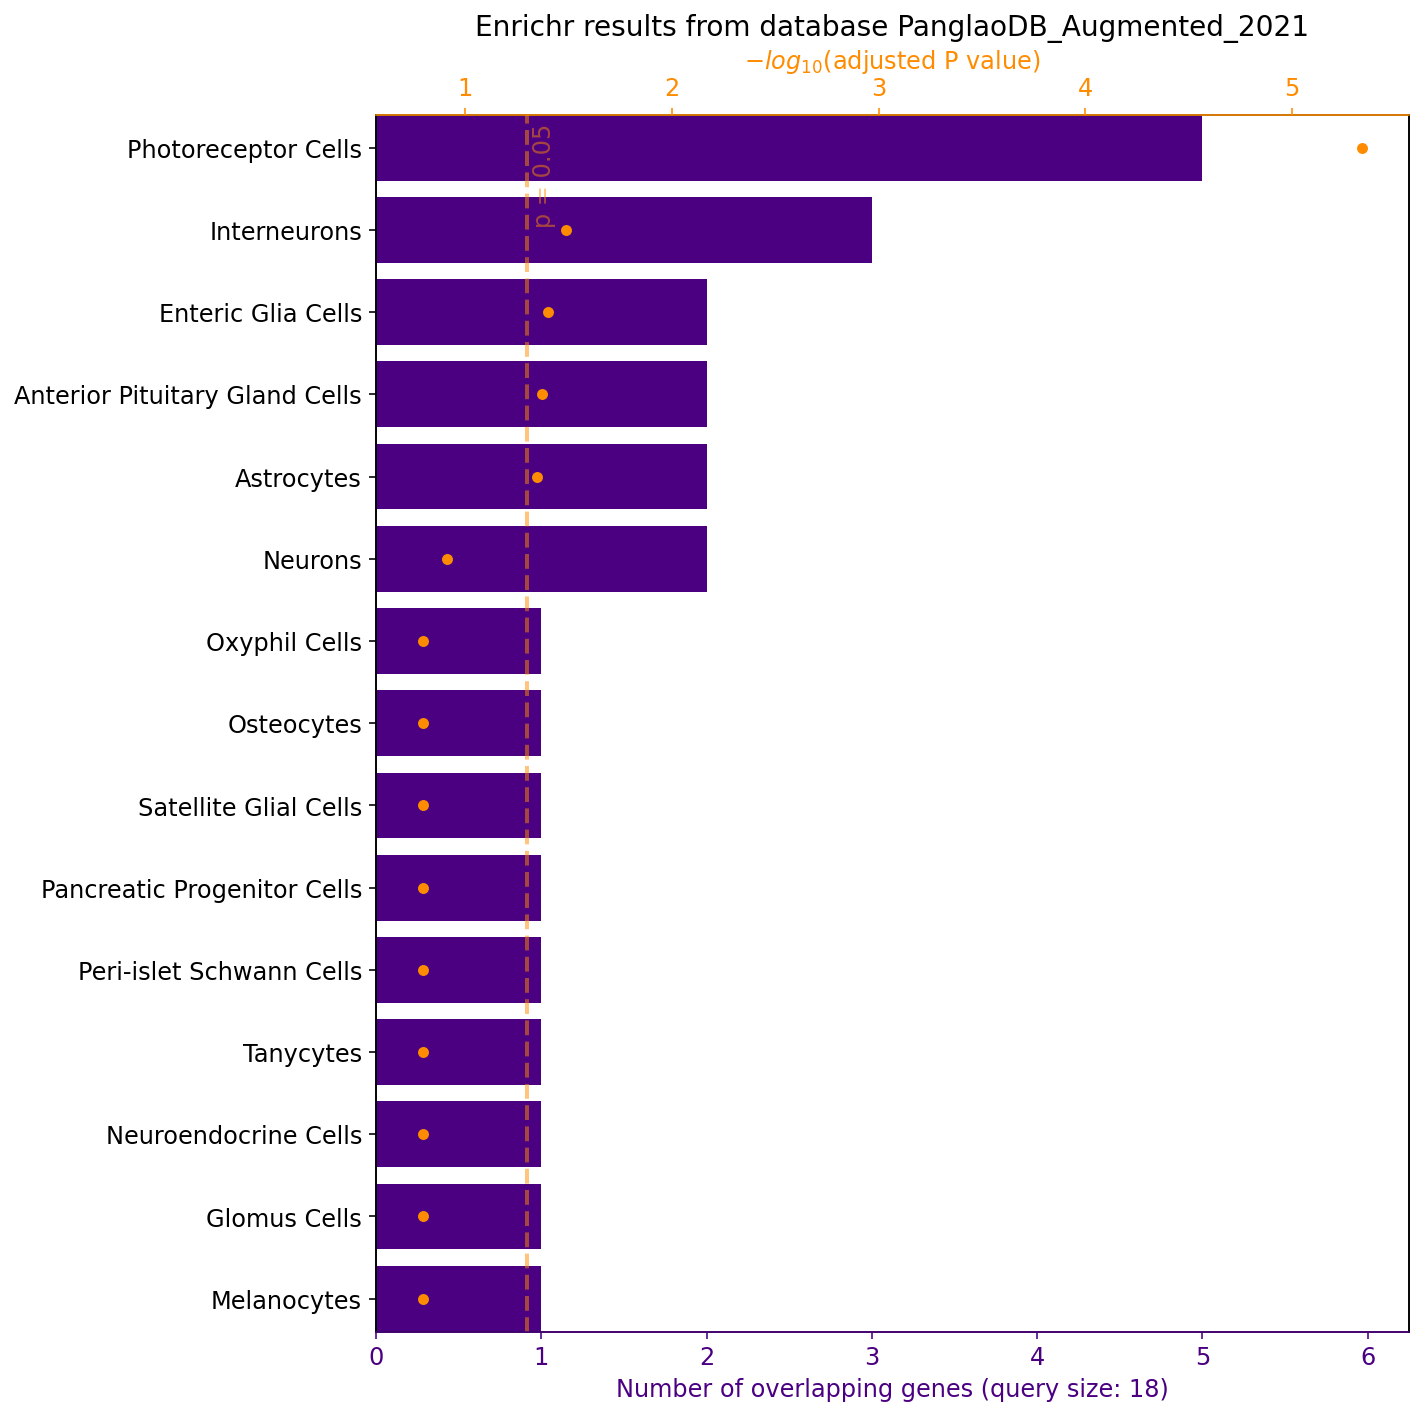

In [4]:
enrichr_df = gget.enrichr(["CYP2J2", 
                           "PRDM8", 
                           "HHATL",
                           "GNB3", 
                           "EDIL3",
                           "TRPM1",
                           "CXCL14",
                           "CPLX3",
                           "CALM1",
                           "CCDC112", 
                           "SYNE1",
                           "CA8",
                           "H2AC20",
                           "ATP6V1H",
                           "RGS16",
                           "TSHB",
                           "CCDC136",
                           "PCP2"], 
                          database="celltypes", 
                          plot=True)

It looks like the differentially expressed genes in the second bipolar cluster are associated with photoreceptor cells. This is very important to know! It is an indication that we might have mislabeled the cells, even though the expression of our known photoreceptor marker genes was low.

# Find correlated genes to gene of interest and its tissue expression using `gget.archs4`:

In [ ]:
df_de_genes.sort_values("logFC", ascending=False).head()

,GeneNames,control,experiment,logFC,p-value,EnsemblID
0,PCP2_ENSMMUG00000060224.1,4.646170,2.347392,2.298778,1.748505e-66,ENSMMUG00000060224.1
1,CCDC136_ENSMMUG00000009625.4,2.646356,0.865758,1.780599,2.061198e-75,ENSMMUG00000009625.4
2,TSHB_ENSMMUG00000058261.1,2.746544,1.143520,1.603024,3.209607e-54,ENSMMUG00000058261.1
3,RGS16_ENSMMUG00000055481.1,2.822387,1.309187,1.513199,1.436695e-58,ENSMMUG00000055481.1
4,ATP6V1H_ENSMMUG00000004064.4,1.896165,0.424468,1.471697,1.912654e-85,ENSMMUG00000004064.4


We can see that the most differentially expressed gene (by fold change) is ENSMMUG00000060224.1 (PCP2). Let's find genes that are co-expressed with PCP2 in the [ArchS4](https://maayanlab.cloud/archs4/) datasets:

In [ ]:
gget.archs4("PCP2")

Wed May 25 04:14:15 2022 INFO Fetching the 100 most correlated genes to PCP2 from ARCHS4.


,gene_symbol,pearson_correlation
1,ACRBP,0.561012
2,STXBP2,0.553554
3,ARHGAP45,0.545050
4,FGD3,0.524292
5,SAP25,0.521339
...,...,...
96,P2RY8,0.447966
97,NFE2,0.447679
98,ADAM8,0.446289
99,PADI4,0.445825


And its tissue exprssion:

In [ ]:
gget.archs4("PCP2", which="tissue")

Wed May 25 04:14:35 2022 INFO Fetching the tissue expression atlas of PCP2 from human ARCHS4 data.


,id,min,q1,median,q3,max
0,System.Nervous System.CNS.CEREBELLUM,0.113644,3.338160,5.078420,6.465170,8.91524
1,System.Immune System.Granulocytic.GRANULOCYTE,0.113644,2.419680,4.082980,5.551400,6.70389
2,System.Immune System.Granulocytic.NEUTROPHIL,0.113644,3.056180,4.055340,4.930370,6.01875
3,System.Immune System.Lymphoid.PLASMACYTOID DEN...,0.113644,2.775950,3.832180,4.420040,5.09377
4,System.Immune System.Lymphoid.TLYMPHOCYTE,0.113644,2.616960,3.769610,4.431110,5.35166
...,...,...,...,...,...,...
67,System.Nervous System.CNS.HYPOTHALAMUS,0.113644,0.113644,0.113644,1.209680,1.20968
68,System.Connective Tissue.Bone.STROMAL CELL,0.113644,0.113644,0.113644,1.209680,2.92457
69,System.Nervous System.CNS.THALAMUS,0.113644,0.113644,0.113644,1.209680,1.91782
70,System.Nervous System.PNS.MOTOR NEURON,0.113644,0.113644,0.113644,0.113644,2.16272


# `gget.seq` and `gget.blast` to find missing gene annotations

We can see in the `gget.info` data frame above that ID ENSMMUG00000021246 belongs to a protein coding gene (see 'biotype') and the protein it encodes might be a HIG1 domain family member. Maybe a BLAST search will tell us more. Let's use a combination of gget.seq and gget.blast to get the nucleotide sequence of this gene and BLAST it:

In [ ]:
# BLAST the first 500 nucleotides of ID ENSMMUG00000021246
blast_results = gget.blast(gget.seq("ENSMMUG00000021246")[1][:500], wrap_text=True)

Wed May 25 03:55:11 2022 INFO Requesting nucleotide sequence of ENSMMUG00000021246 from Ensembl.
Wed May 25 03:55:11 2022 INFO Sequence recognized as nucleotide sequence.
Wed May 25 03:55:11 2022 INFO BLAST will use program 'blastn' with database 'nt'.
Wed May 25 03:55:12 2022 INFO BLAST initiated with search ID 8VA5068W013. Estimated time to completion: 30 seconds.
Wed May 25 03:55:44 2022 INFO Retrieving results...


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"MACACA MULATTA BAC cloneCH250-293L3 from chromosome 2,complete sequence",Macaca mulatta,Rhesus monkey,9544,924.0,924.0,100%,0.000000e+00,100.00%,185684,AC198108.4
1,"PREDICTED: Macaca fascicularisHIG1 hypoxia inducible domainfamily member 1A (HIGD1A),transcript variant X3, mRNA",Macaca fascicularis,crab-eating macaque,9541,874.0,874.0,100%,0.000000e+00,98.20%,1886,XM_045386419.1
2,"PREDICTED: Macaca fascicularisprotein MIX23-like(LOC123571841), misc_RNA",Macaca fascicularis,crab-eating macaque,9541,874.0,874.0,100%,0.000000e+00,98.20%,3936,XR_006696116.1
3,Rhesus Macaque BACCH250-455N24 () completesequence,Macaca mulatta,Rhesus monkey,9544,874.0,874.0,100%,0.000000e+00,98.20%,175273,AC196812.6
4,"PREDICTED: Macaca fascicularisHIG1 hypoxia inducible domainfamily member 1A (HIGD1A),transcript variant X2, mRNA",Macaca fascicularis,crab-eating macaque,9541,619.0,619.0,71%,1.000000e-172,97.78%,1661,XM_005546793.3
5,"Homo sapiens chromosome 3clone RP11-141M3, completesequence",Homo sapiens,human,9606,544.0,544.0,99%,6.000000e-150,87.03%,176140,AC092043.3
6,"Homo sapiens chromosome 3clone RP11-70C1, completesequence",Homo sapiens,human,9606,544.0,544.0,99%,6.000000e-150,87.03%,167667,AC099329.2
7,"Homo sapiens genomic sequencesurrounding NotI site, cloneNR5-IB17C",Homo sapiens,human,9606,531.0,531.0,99%,5.000000e-146,86.43%,688,AJ335291.1
8,"Homo sapiens genomic sequencesurrounding NotI site, cloneNL1-BL15C",Homo sapiens,human,9606,494.0,494.0,99%,6.000000e-135,85.23%,666,AJ334781.1
9,"PREDICTED: Colobus angolensispalliatus HIG1 hypoxiainducible domain family,member 1A (HIGD1A), transcriptvariant X1, mRNA",Colobus angolensis palliatus,NaN,336983,451.0,451.0,57%,4.000000e-122,94.83%,633,XM_011950965.1


The BLAST hits suggest that this gene might be HIG1 hypoxia inducible domain family member 1A (HIGD1A). This would confirm the database entry on the encoded protein.



___

# `gget.blast` to confirm existing gene annotation

Let's take a look at another DE gene, CCDC136_ENSMMUG00000009625.4. Unlike the previous gene, this gene is annotated with gene name CCDC136. Let's BLAST it:

In [ ]:
blast_results = gget.blast(gget.seq("ENSMMUG00000009625")[1][:500], wrap_text=True)

Wed May 25 03:55:45 2022 INFO Requesting nucleotide sequence of ENSMMUG00000009625 from Ensembl.
Wed May 25 03:55:45 2022 INFO Sequence recognized as nucleotide sequence.
Wed May 25 03:55:45 2022 INFO BLAST will use program 'blastn' with database 'nt'.
Wed May 25 03:55:46 2022 INFO BLAST initiated with search ID 8VA612M4016. Estimated time to completion: 30 seconds.
Wed May 25 03:56:18 2022 INFO Retrieving results...


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"Pan troglodytes BAC cloneCH251-587P5 from chromosome 7,complete sequence",Pan troglodytes,chimpanzee,9598,802,802,100%,0.000000e+00,95.60%,201552,AC192999.3
1,"Homo sapiens chromosome 7clone RP11-66F23, completesequence",Homo sapiens,human,9606,791,791,100%,0.000000e+00,95.20%,182426,AC024952.4
2,"PREDICTED: Cercocebus atysopsin 1 (cone pigments),short-wave-sensitive (OPN1SW),transcript variant X1, mRNA",Cercocebus atys,sooty mangabey,9531,322,322,35%,3.000000e-83,99.44%,3367,XM_012087992.1
3,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X8, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,1848,XM_015134871.2
4,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X7, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,2722,XM_028846261.1
5,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X6, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,2991,XM_028846260.1
6,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X5, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,3459,XM_015134870.2
7,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X4, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,3439,XM_015134869.2
8,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X3, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,4060,XM_001090156.4
9,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X2, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,3790,XM_015134867.2


It looks like the BLAST suggest the gene also aligns to a prediction for OPN1SW, which encodes short wave sensitive cone pigments. It is unclear which annotation is correct (CCDC136 or OPN1SW?), but this is important to know about a gene of interest.
___

# `gget.blat` to assess genome locations of DE genes

Sometimes genes may be up-/down-regulated due to proximity to another up-/down-regulated gene. Let's combine gget.seq and gget.blat to quickly get the chromosome locations of all DE genes. Since no mucaca genomes are available for BLAT, we will use the default human genome:

In [ ]:
df_list = []

for id in df_de_genes["EnsemblID"].values:
    # Use gget.seq to get the nucleotide sequence
    seq = gget.seq(id)

    # Only keep the first (best) result for each sequence
    df_list.append(gget.blat(seq[1]).head(1))

# Concatenate the result data frames    
df_blat = pd.concat(df_list)
df_blat = df_blat.reset_index(drop=True)
# Add gene names and logFC to BLAT results data frame
df_blat["gene"] = ens_ids
df_blat["logFC"] = df_de_genes["logFC"].values

Wed May 25 03:56:20 2022 INFO Requesting nucleotide sequence of ENSMMUG00000015972 from Ensembl.
Wed May 25 03:56:20 2022 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
Wed May 25 03:56:20 2022 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
Wed May 25 03:56:23 2022 INFO Requesting nucleotide sequence of ENSMMUG00000051357 from Ensembl.
Wed May 25 03:56:23 2022 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
Wed May 25 03:56:23 2022 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
Wed May 25 03:56:25 2022 INFO Requesting nucleotide sequence of ENSMMUG00000054106 from Ensembl.
Wed May 25 03:56:25 2022 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
Wed May 25 03:56:25 2022 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
Wed May 25 03:56:27 2022 INFO Requesting nucle

In [ ]:
df_blat

,genome,query_size,aligned_start,aligned_end,matches,mismatches,%_aligned,%_matched,chromosome,strand,start,end,gene,logFC
0,hg38,8000,39,8000,7330,427,99.52,92.06,chr1,-,59918571,59926784,ENSMMUG00000015972.4,0.726937
1,hg38,8000,8,8000,7432,394,99.91,92.98,chr4,+,80183853,80191788,ENSMMUG00000051357.1,0.732278
2,hg38,8000,1,8000,7589,348,100.00,94.86,chr8,+,64373309,64381298,ENSMMUG00000054106.1,0.732451
3,hg38,8000,1,8000,7430,287,100.00,92.88,chr7,+,94656370,94664403,ENSMMUG00000053116.1,0.744658
4,hg38,8000,1,7959,6809,372,99.49,85.55,chr3,-,42794545,42804512,ENSMMUG00000021246.4,0.774762
5,hg38,6396,1,6396,6015,311,100.00,94.04,chr12,+,6840936,6847390,ENSMMUG00000005190.4,0.805701
6,hg38,8000,1,8000,7511,354,100.00,93.89,chr5,-,84376503,84384880,ENSMMUG00000007661.4,0.806820
7,hg38,8000,1,8000,7164,527,100.00,89.55,chr15_KN538374v1_fix,-,3320867,3334271,ENSMMUG00000009430.4,0.856603
8,hg38,3784,1,3784,3480,220,100.00,91.97,chr11,+,84972951,84976703,ENSMMUG00000051202.1,0.873754
9,hg38,8000,2,7369,5677,552,92.10,77.05,chr16,+,56625770,56637608,ENSMMUG00000054142.1,0.874762


Check how the DE genes are distributed at the chromosome level:

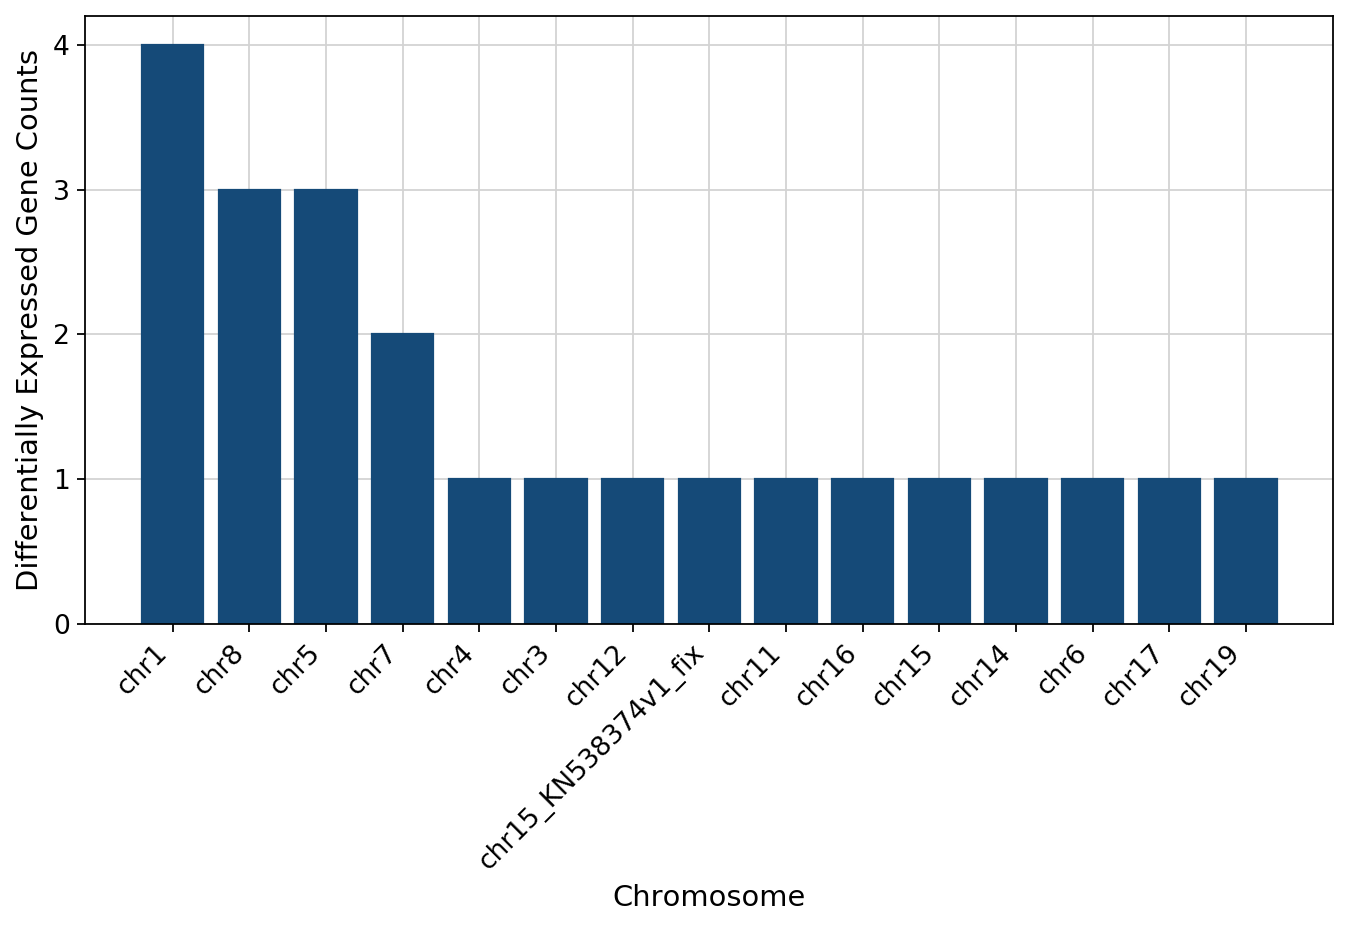

In [ ]:
# Plot gene counts per chromosome 
funcs.chr_locations(df_blat)

For a complete analysis of the genome locations of the DE genes, you could compare the exact chromosome locations for genes on the same chromosome as a next step (these are given by the `gget.blat` columns "start" and "end").

___

# Isoform analysis with `gget.info`, `gget.seq` and `gget.muscle`

Expand info to get the names of all known isoforms (see colukmn "all_transcripts"):

In [ ]:
info_df2 = gget.info("ENSMMUG00000009625", expand=True, wrap_text=True)

Wed May 25 03:57:20 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000009625. Returning all unreviewed results.


,ensembl_id,uniprot_id,ncbi_gene_id,species,assembly_name,primary_gene_name,ensembl_gene_name,synonyms,parent_gene,protein_names,ensembl_description,uniprot_description,ncbi_description,object_type,biotype,canonical_transcript,seq_region_name,strand,start,end,all_transcripts,transcript_biotypes,transcript_names,all_exons,exon_starts,exon_ends,all_translations,translation_starts,translation_ends
ENSMMUG00000009625,ENSMMUG00000009625,"[A0A5F7ZA03, A0A5F7ZL74, A0A5F7ZT08, A0A5F8A4T9, A0A5F8AAY4, F6YQZ1, F6YR10, F6YR17, F6ZYP2, F7H6P6]",701874,macaca_mulatta,Mmul_10,CCDC136,CCDC136,[CCDC136],NaN,Coiled-coil domain containing 136,coiled-coil domain containing136 [Source:VGNCSymbol;Acc:VGNC:70836],NaN,NaN,Gene,protein_coding,ENSMMUT00000086187.1,3,1,155039982,155081843,"[ENSMMUT00000041838, ENSMMUT00000094799, ENSMMUT00000086187, ENSMMUT00000013452, ENSMMUT00000081345, ENSMMUT00000092110, ENSMMUT00000013450, ENSMMUT00000013440, ENSMMUT00000096620, ENSMMUT00000013454]","[protein_coding, protein_coding, protein_coding, protein_coding, protein_coding, protein_coding, protein_coding, protein_coding, protein_coding, protein_coding]","[CCDC136-201, CCDC136-209, CCDC136-208, CCDC136-207, CCDC136-206, CCDC136-205, CCDC136-204, CCDC136-203, CCDC136-202, CCDC136-210]",NaN,NaN,NaN,NaN,NaN,NaN


We can use `seqtype="transcript"` and `isoforms=True` with `gget.seq` to get the amino acid sequences of all known transcripts from our gene ID:

In [ ]:
gget.seq("ENSMMUG00000009625", isoforms=True, seqtype="transcript", save=True)

Wed May 25 03:57:25 2022 WARNING No reviewed UniProt results were found for Ensembl ID ENSMMUG00000009625. Returning all unreviewed results.
Wed May 25 03:57:27 2022 INFO Requesting amino acid sequences of all transcripts of gene ENSMMUG00000009625 from UniProt.


['>ENSMMUT00000041838 uniprot_id: F7H6P6 ensembl_id: ENSMMUT00000041838 gene_name(s): CCDC136 organism: Macaca mulatta (Rhesus macaque) sequence_length: 721',
 'MEAGAGAGAGAAGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEEEEVEEEEEQVQKGGSVGSLSVNKHRGLSLTETELEELRAQVLQLVAELEETRELAGQHEDDSLELQGLLEDERLASAQQAEVFTKQIQQLQGELRSLREEISLLEHEKESELKEIERELHLAQAEIQSLRQAAEDSATEHESDIASLQEDLCRMQNELEDMERIRGDYEMEIASLRAEMEMKSSEPSSSLGLSDYSGLQEELQELRERYHFLNEEYRALQESNSSLTGQLADLESERTQRATERWLESQTLSMTSAESQTSEMDFLEPDPEMQLLRQQLRDAEEQMHGMKNKCQELCCELEELQHHRQVSEEEQRRLQRELKCAQNEVLRFQTSHSVTQHFEEMVAKVLIKLQAVQAMYQISQEEHSQLQEQMEKLLAKQKDLKEELDACEREFKECMECLEKPVAPQNDKNEIKELQTKLRELQLQYQASMDEQGRLLVVQEQLEGQLQCCQEELRQLREKRPSVVKEARGKNANKNMNKNANGVKMKKVIKPCSDTSESDFETRKSLEVVLYYKASQRKLDGLAKEEEKKEEMKEEKKEEVKEEAKEQCGDELVAEPADPGEAKSTEDQEENEEDKEQEEKEEDSEEEEDDIDSSLESPEENNPLRLSESKKSSPTPDPPIFSLPLVGLVVISALLWCWWAETSS',
 '>ENSMMUT00000094799 uniprot_id: A0A5F7ZA03 ensembl_id: ENSMMUT00000094799 gene_name(s): CCDC136 organism: Macaca 

How do these isoforms differ from each other? Let's align them!

In [ ]:
gget.muscle("gget_seq_results.fa")

Wed May 25 03:57:29 2022 INFO MUSCLE compiled. 
Wed May 25 03:57:29 2022 INFO MUSCLE aligning... 

muscle 5.2.linux64 [00617b]  13.3Gb RAM, 2 cores
Built Apr 13 2022 00:43:46
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 10 seqs, avg length 858, max 1208

00:00 38Mb   CPU has 2 cores, running 2 threads
00:08 197Mb   100.0% Calc posteriors
00:08 197Mb   100.0% Consistency (1/2)
00:08 197Mb   100.0% Consistency (2/2)
00:08 197Mb   100.0% UPGMA5
00:09 197Mb   100.0% Refining
Wed May 25 03:57:38 2022 INFO MUSCLE alignment complete. Alignment time: 8.9 seconds




ENSMMUT00000081345 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013452 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000096620 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013440 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000041838 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013454 MSPSLHPSPQPVPHPPALPFSV-LSGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000092110 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013450 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000086187 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000094799 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEE